# Movie recommendation app 
### Ashok Gadde
### Eric Spangler
### Michel Holister
### Comp 7118 Data Mining
### Fall 2018


This app is broken up into 2 components. The ratings module provides the ratings recommendation algorithms and data input. For this evaluation, we have chosen the 2 movielens movie and rating file provided by Dr. Phan. Calling the object requires passing the movie list and rating list files in csv format:


In [6]:
from ratings import ratings
movieFilename='movielens/movies.csv'
ratingFilename='movielens/ratings.csv'

print("Loading Data...")

rData=ratings(movieFilename,ratingFilename)

print("Done.")


Loading Data...
Done.


### Overview of the get_clustering member
#### Vectorizing the data
In the clustering methods section of ratings.py, the get_clustering method provides a simple interface for a crucial step in determining the cluster indexing of a movie data set. Prior to clustering, the data needs to be converted to a vectorized format, i.e. a format that can be indexed sequentially rather than through arbitrary labels. In sklearn, the DictVectorizer can generate a sparse matrix for efficient clustering and component analysis.

In [3]:
from sklearn.feature_extraction import DictVectorizer

print("Generating a sparse matrix for clustering algorithms...")

v=DictVectorizer(sparse=True)

R=[rData.ratings_by_movie_id_for_sklearn[d] for d in rData.ratings_by_movie_id_for_sklearn]
X=v.fit_transform(R)

print("Done.")

Generating a sparse matrix for clustering algorithms...
Done.


After vectorizing the input data, we can provide the transformed data to a clustering algorithm like K Means in the sklearn.cluster package to get a list of closely related movies.

In [4]:
from sklearn.cluster import KMeans
print("Generating 40 clusters with 5000 max steps via K Means...")

clusterizer=KMeans(n_clusters=40,max_iter=5000,n_jobs=8)
clustering=clusterizer.fit_predict(X)

print("Done.")

Generating 40 clusters with 5000 max steps via K Means...
Done.


### Evaluation of the get_clustering member
#### Principle Component Analysis
K Means can help us organize the data, but unfortunately, it doesn't give an impression of how the data is oranized. Or even if the data is organized at all. To help visualize the clustering, and ultimately verify it works, we can use a different approach such as Principle Component Analysis (PCA). Certain methods, such as singular value decomposition (SVD), can help to expose the principal components of the underlying data in the movie set.

In [7]:
from sklearn.decomposition import TruncatedSVD
print('Obtaining 40 PCA components of movie ratings for visualization.')

svd = TruncatedSVD(n_components=40)
x=svd.fit_transform(X)
print("Done.")

Obtaining 40 PCA components of movie ratings for visualization.
Done.


40 components are chosen to represent the axii of our set, but unfortuneatly, it is quite difficult to faithfully represent the data in a meaningful way. While the data may be complex, the underlying features are still lineariazable to some mapping. Using t-distributed stochastic neighbor embedding, we can reduce the dimension of the underlying data to just 2 components. 

In [8]:
print('Reducing dimension of PCA to 2 for t-distributed Stochastic Neighbor Embedding visualization.')
from sklearn.manifold import TSNE
#x = TSNE(n_components=3).fit_transform(X.toarray())
x_TSNE = TSNE(n_components=2, perplexity = 100, n_iter=10000).fit_transform(x)
print(x_TSNE)

Reducing dimension of PCA to 2 for t-distributed Stochastic Neighbor Embedding visualization.
[[-25.92144     21.304039  ]
 [ -1.2658387  -36.575096  ]
 [-23.363409    24.525414  ]
 ...
 [ 36.541492     2.8529615 ]
 [ 39.257915     0.07253712]
 [ 38.390167     4.935791  ]]


Assuming we have the correct clusters and that the principle components are an accurate representation of the data, we can obtain the cluster centers to verify the quality of the clustering:

Movie clusters generated by K-Means match their respective PCA embedding within the 
t-distributed Stochastic Neighbor Embedding:


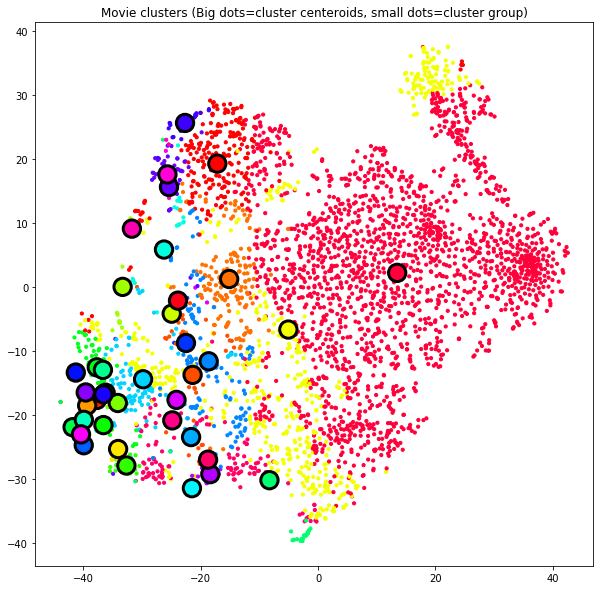

In [11]:
import matplotlib.pyplot as plt
import numpy as np

print('Movie clusters generated by K-Means match their respective PCA embedding within the ')
print('t-distributed Stochastic Neighbor Embedding:')
plt.figure(figsize=(10, 10))
plt.subplot(111)

plt.scatter(x_TSNE[:,0], x_TSNE[:,1],  c=clustering,s=10,cmap=plt.cm.hsv)

centers=np.array([[0.0,0.0]]*40)
nCenters=[0]*40
c=[0]*40
for i in range(0,len(clustering)):
    centers[clustering[i]]=x_TSNE[i]+centers[clustering[i]]
    nCenters[clustering[i]]=nCenters[clustering[i]]+1
    c[clustering[i]]=clustering[i]
for i in range(0,40):
    centers[i]=centers[i]/nCenters[i]
plt.scatter(centers[:,0],centers[:,1], c=c,s=300,cmap=plt.cm.hsv,edgecolors='k',linewidths=3)

plt.title("Movie clusters (Big dots=cluster centeroids, small dots=cluster group)")
plt.show()

In [12]:
print('A sample of the first 30 movies with their respective cluster:')
print('--------------------------------------------------------------')
pCount=0
table=[['Cluster','Movie Title']]
for i,j in zip(rData.ratings_by_movie_id,range(0,len(rData.movies))):
    if pCount<30:
        table.append([clustering[j],rData.movies[i]['title']])
        pCount=pCount+1
for i in table:
    print(i[0],'\t',i[1])


A sample of the first 30 movies with their respective cluster:
--------------------------------------------------------------
Cluster 	 Movie Title
34 	 One Flew Over the Cuckoo's Nest (1975)
37 	 James and the Giant Peach (1996)
16 	 My Fair Lady (1964)
2 	 Erin Brockovich (2000)
22 	 Bug's Life, A (1998)
6 	 Princess Bride, The (1987)
9 	 Ben-Hur (1959)
12 	 Christmas Story, A (1983)
16 	 Snow White and the Seven Dwarfs (1937)
16 	 Wizard of Oz, The (1939)
16 	 Beauty and the Beast (1991)
0 	 Gigi (1958)
0 	 Miracle on 34th Street (1947)
6 	 Ferris Bueller's Day Off (1986)
16 	 Sound of Music, The (1965)
6 	 Airplane! (1980)
37 	 Tarzan (1999)
16 	 Bambi (1942)
23 	 Awakenings (1990)
6 	 Big (1988)
2 	 Pleasantville (1998)
3 	 Wallace & Gromit: The Best of Aardman Animation (1996)
6 	 Back to the Future (1985)
11 	 Schindler's List (1993)
23 	 Meet Joe Black (1998)
7 	 Pocahontas (1995)
13 	 E.T. the Extra-Terrestrial (1982)
31 	 Titanic (1997)
38 	 Ponette (1996)
3 	 Close Shave, A 

In [76]:
print('A sample of movies in cluster 16:')
print('--------------------------------------------------------------')
pCount=0
table=[['Cluster','Movie Title']]
for i,j in zip(rData.ratings_by_movie_id,range(0,len(rData.movies))):
    if clustering[j]==21 and pCount<30:
        table.append([clustering[j],rData.movies[i]['title']])
for i in table:
    print(i[0],'\t',i[1])

A sample of movies in cluster 16:
--------------------------------------------------------------
Cluster 	 Movie Title
21 	 U.S. Marshalls (1998)
21 	 Cliffhanger (1993)
21 	 Backdraft (1991)
21 	 Outbreak (1995)
21 	 Maverick (1994)
21 	 Lost World: Jurassic Park, The (1997)
21 	 Ronin (1998)
21 	 Payback (1999)
21 	 Alien: Resurrection (1997)
21 	 Demolition Man (1993)
21 	 Last of the Mohicans, The (1992)
21 	 Thin Red Line, The (1998)
21 	 Con Air (1997)
21 	 Twister (1996)
21 	 Broken Arrow (1996)
21 	 Armageddon (1998)
21 	 Conspiracy Theory (1997)
21 	 Desperado (1995)
21 	 Die Hard: With a Vengeance (1995)
21 	 Under Siege (1992)
21 	 Lethal Weapon 3 (1992)
21 	 Mask of Zorro, The (1998)
21 	 Dragonheart (1996)
21 	 Blade (1998)
21 	 Ghost and the Darkness, The (1996)
21 	 Young Guns (1988)
21 	 Mummy, The (1999)
21 	 Natural Born Killers (1994)
21 	 X-Men (2000)
21 	 Negotiator, The (1998)
21 	 Heat (1995)
21 	 Sleepy Hollow (1999)
21 	 Falling Down (1993)
21 	 Tomorrow Never 

Displaying cluster 10 within the t-distributed Stochastic Neighbor Embedding:


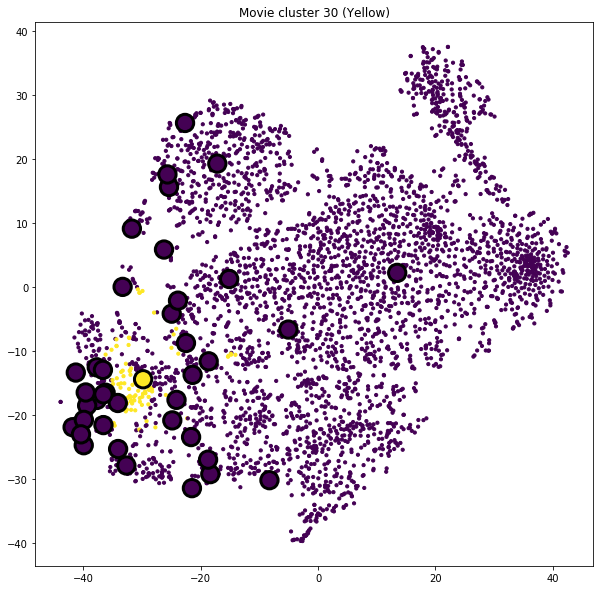

In [89]:
print('Displaying cluster 10 within the t-distributed Stochastic Neighbor Embedding:')
plt.figure(figsize=(10, 10))
plt.subplot(111)
clusterN=[0]*len(clustering)
#print(clustering)
#c=[0]*40
#for i in range(0,len(clustering)):
#    if clustering[i]==21:
#        clusterN[i]=1#clustering[i]
#        c[21]=33#30

#print(clusterN)

#plt.scatter(centers[:,0],centers[:,1], c=c,s=300,edgecolors='k',linewidths=3)

centers=np.array([[0.0,0.0]]*40)
nCenters=[0]*40
c=[0]*40
for i in range(0,len(clustering)):
    centers[clustering[i]]=x_TSNE[i]+centers[clustering[i]]
    nCenters[clustering[i]]=nCenters[clustering[i]]+1
    if clustering[i]==21:
        clusterN[i]=9
        c[clustering[i]]=9
    else:
        clusterN[i]=4
        c[clustering[i]]=4
for i in range(0,40):
    centers[i]=centers[i]/nCenters[i]

plt.scatter(x_TSNE[:,0], x_TSNE[:,1],  c=clusterN,s=10)
plt.scatter(centers[:,0],centers[:,1], c=c,s=300,edgecolors='k',linewidths=3)
#print(clusterN)
#print(clustering)
plt.title("Movie cluster 30 (Yellow)")
plt.show()

Utilizing a different clustering method, Birch clusteringm, we see slightly different results. A little noise pervades the system.

In [17]:
from sklearn.cluster import Birch
birchClusterizer=Birch(n_clusters=40)
birchClustering=birchClusterizer.fit_predict(X)
print(len(birchClustering))

/Users/ericspangler/anaconda3/lib/python3.7/site-packages/sklearn/cluster/birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node1_dist, node2_dist = dist[[farthest_idx]]


3706


Movie clusters generated by Birch match their respective PCA embedding within the 
t-distributed Stochastic Neighbor Embedding:


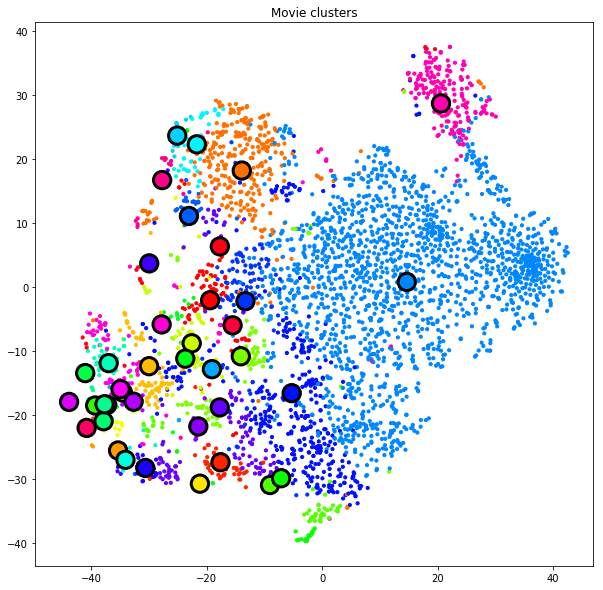

In [18]:
print('Movie clusters generated by Birch match their respective PCA embedding within the ')
print('t-distributed Stochastic Neighbor Embedding:')
plt.figure(figsize=(10, 10))
plt.subplot(111)

plt.scatter(x_TSNE[:,0], x_TSNE[:,1],  c=birchClustering,s=10,cmap=plt.cm.hsv)

centers=np.array([[0.0,0.0]]*40)
nCenters=[0]*40
c=[0]*40
for i in range(0,len(birchClustering)):
    centers[birchClustering[i]]=x_TSNE[i]+centers[birchClustering[i]]
    nCenters[birchClustering[i]]=nCenters[birchClustering[i]]+1
    c[clustering[i]]=clustering[i]
for i in range(0,40):
    centers[i]=centers[i]/nCenters[i]
plt.scatter(centers[:,0],centers[:,1], c=c,s=300,cmap=plt.cm.hsv,edgecolors='k',linewidths=3)

plt.title("Movie clusters")
plt.show()

And even more interesting, agglomerative clustering. Which seems to show a more complete cover of the data set.

In [91]:
from sklearn.cluster import AgglomerativeClustering
AgglomerativeClusterizer=AgglomerativeClustering(n_clusters=40)
AgglomerativeClusters=AgglomerativeClusterizer.fit_predict(X.toarray())
print(len(AgglomerativeClusters))

3706


Movie clusters generated by Agglomerative Clustering match their respective PCA embedding within the 
t-distributed Stochastic Neighbor Embedding:
<class 'sklearn.cluster.hierarchical.AgglomerativeClustering'>


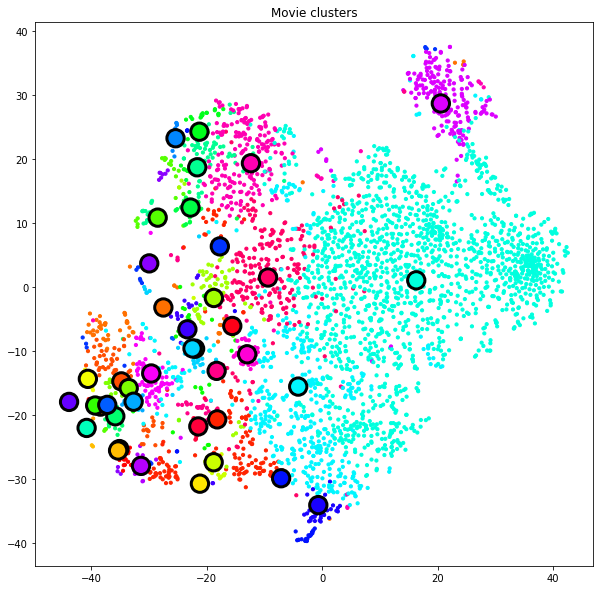

In [93]:
print('Movie clusters generated by Agglomerative Clustering match their respective PCA embedding within the ')
print('t-distributed Stochastic Neighbor Embedding:')
plt.figure(figsize=(10, 10))
plt.subplot(111)

plt.scatter(x_TSNE[:,0], x_TSNE[:,1],  c=AgglomerativeClusters,s=10,cmap=plt.cm.hsv)
centers=np.array([[0.0,0.0]]*40)
print(AgglomerativeClustering)
nCenters=[0]*40
c=[0]*40
for i in range(0,len(AgglomerativeClusters)):
    centers[AgglomerativeClusters[i]]=x_TSNE[i]+centers[AgglomerativeClusters[i]]
    nCenters[AgglomerativeClusters[i]]=nCenters[AgglomerativeClusters[i]]+1
    c[AgglomerativeClusters[i]]=AgglomerativeClusters[i]
for i in range(0,40):
    centers[i]=centers[i]/nCenters[i]
plt.scatter(centers[:,0],centers[:,1], c=c,s=300,cmap=plt.cm.hsv,edgecolors='k',linewidths=3)

plt.title("Movie clusters")
plt.show()